In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import cross_val_score, cross_validate 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('cardio_train.csv' , sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.isnull().values.any()
#No null values

False

In [4]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
#Height and weight consists of outliers. Hence dropping the values before 0.025 and 0.975

Diastilic pressure is higher than systolic one in 1082 cases


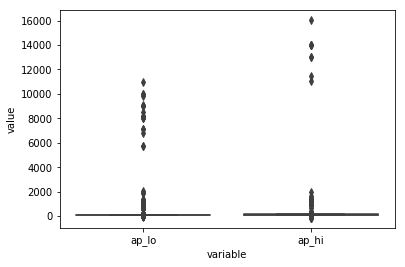

In [5]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

In [6]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
#Dropping values where diastolic pressure is higher than systolic pressure

Diastilic pressure is higher than systolic one in 0 cases


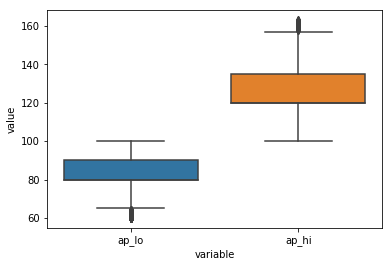

In [7]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

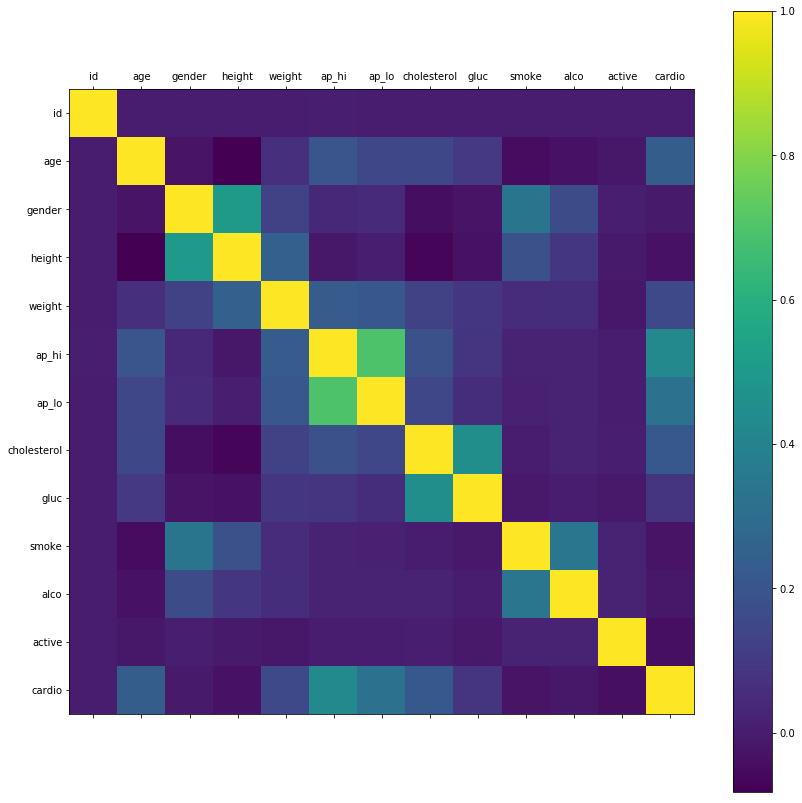

In [8]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(df.corr())
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.xticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()

#Correlation matrix gives an idea on the correlation of features 

In [9]:
df['age'] = round((df['age']/365))
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [16]:
#split data into featureed and what we are trying to predict
feature_cols = ['age', 'gender', 'height', 'weight', 'ap_hi','ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = df[feature_cols]
y = df.cardio

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# fit a classification tree with max_depth=5
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)

# Fit our training data
treeclf.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

Training accuracy: 0.726121760611891
Testing accuracy : 0.7219974505348334


In [21]:
# use crossvalidation to get avg accuracy
#from sklearn.cross_validation import cross_val_score    NOTE:  This has changed to the following
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
print("Accuracy for each fold: {}".format(scores))
print("Mean Accuracy: {}".format(np.mean(scores)))

Accuracy for each fold: [0.7263658  0.72589074 0.73111639 0.7192399  0.72660333 0.71852732
 0.7263658  0.72327791 0.72137767 0.72202423]
Mean Accuracy: 0.724078907939045


In [22]:
#from sklearn.learning_curve import validation_curve   NOTE: this has changeed to:
from sklearn.model_selection import validation_curve

# depth takes values from 1 to 10
max_depth_range = range(1, 11)

# do 10-fold cross-validation for each value in max_depth_range and return the accuracy scores. 
train_scores, valid_scores = validation_curve( treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range,
    cv=10, scoring="accuracy")


In [23]:
#Size of train_scores will be: length of parameter (max_depth_range) X number of folds
print(train_scores.shape)

(10, 10)


Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

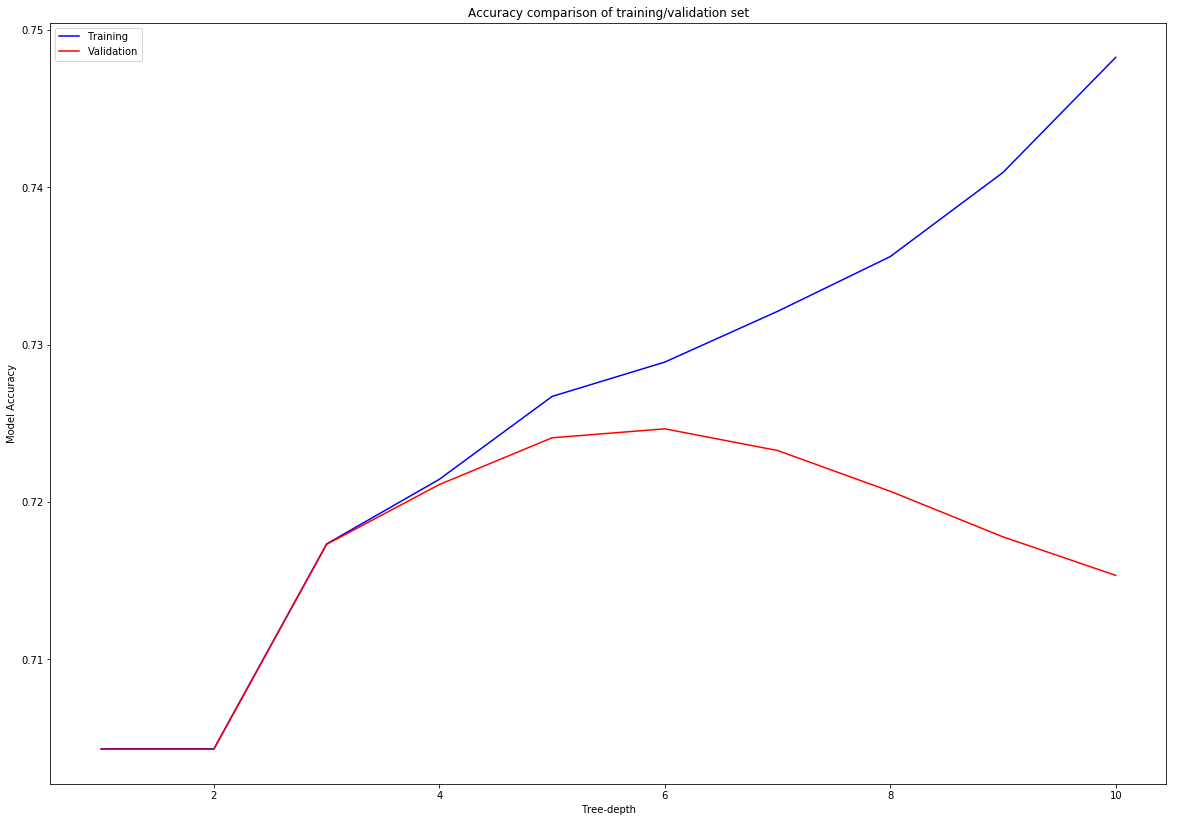

In [24]:
# Mean accuracy score for each value of max-depth
mean_train_score = np.mean(train_scores, axis=1) 
mean_val_score   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")

In [26]:
treeclf = DecisionTreeClassifier(max_depth=6)
treeclf.fit(Xtrain,ytrain)
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

Training accuracy: 0.7282595786123186
Testing accuracy : 0.7222191431580114
